<a href="https://colab.research.google.com/github/Rajsoni03/Sentiment-Analysis-of-Amazon-Product-Reviews/blob/main/Marge_Data_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Librtaries

In [46]:
import tensorflow as tf
import tensorflow_hub as hub

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
import json
import gzip
from urllib.request import urlopen

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

# Download and Import the Amazon Review Data (2018) Dataset


Dataset Link - https://nijianmo.github.io/amazon/index.html

In [2]:
# download review data zip file

!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Clothing_Shoes_and_Jewelry_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Books_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Home_and_Kitchen_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Kindle_Store_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Sports_and_Outdoors_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Toys_and_Games_5.json.gz

--2022-02-24 11:39:13--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169071325 (161M) [application/octet-stream]
Saving to: ‘Cell_Phones_and_Accessories_5.json.gz’

Cell_Phones_and_Acc 100%[===================>] 161.24M  45.3MB/s    in 4.0s    

2022-02-24 11:39:18 (40.5 MB/s) - ‘Cell_Phones_and_Accessories_5.json.gz’ saved [169071325/169071325]

--2022-02-24 11:39:18--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53965563 (51M) [application/octet-stream]
Saving to: ‘Arts_Crafts_and_Sewin

In [3]:
data_set_name = {
    1 : 'Cell_Phones_and_Accessories',
    2 : 'Arts_Crafts_and_Sewing',
    3 : 'Clothing_Shoes_and_Jewelry',
    4 : 'Books',
    5 : 'Electronics',
    6 : 'Kindle_Store',
    7 : 'Sports_and_Outdoors',
    8 : 'Toys_and_Games'
}

In [4]:
def extract_data(data_name):
  # load the meta data
  data = []
  path = '/content/'+ data_name + '_5.json.gz'
  count = 0
  with gzip.open(path) as f:
    for l in f:
      if count < 100000:
        data.append(json.loads(l.strip()))
      count += 1
      
  # total length of list, this number equals total number of products
  print(f'{len(data)}/{count}', ' : ', data_name)

  return data

In [5]:
data = {}
for data_name in data_set_name.values():
  data[data_name] = extract_data(data_name)

100000/1128437  :  Cell_Phones_and_Accessories
100000/494485  :  Arts_Crafts_and_Sewing
100000/11285464  :  Clothing_Shoes_and_Jewelry
100000/27164983  :  Books
100000/6739590  :  Electronics
100000/2222983  :  Kindle_Store
100000/2839940  :  Sports_and_Outdoors
100000/1828971  :  Toys_and_Games


# Data Analysis for Cell_Phones_and_Accessories

In [6]:
# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data['Cell_Phones_and_Accessories'])

# show 5 rows from head
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"08 4, 2014",A24E3SXTC62LJI,7508492919,{'Color:': ' Bling'},Claudia Valdivia,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,1407110400,NaN,NaN
1,5.0,True,"02 12, 2014",A269FLZCB4GIPV,7508492919,NaN,sarah ponce,When you don't want to spend a whole lot of ca...,1,1392163200,NaN,NaN
2,3.0,True,"02 8, 2014",AB6CHQWHZW4TV,7508492919,NaN,Kai,"so the case came on time, i love the design. I...",Its okay,1391817600,NaN,NaN
3,2.0,True,"02 4, 2014",A1M117A53LEI8,7508492919,NaN,Sharon Williams,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,1391472000,NaN,NaN
4,4.0,True,"02 3, 2014",A272DUT8M88ZS8,7508492919,NaN,Bella Rodriguez,"I liked it because it was cute, but the studs ...",Cute!,1391385600,NaN,NaN


In [7]:
df = df[['overall', 'reviewText']]
df.head()

,overall,reviewText
0,5.0,Looks even better in person. Be careful to not...
1,5.0,When you don't want to spend a whole lot of ca...
2,3.0,"so the case came on time, i love the design. I..."
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...
4,4.0,"I liked it because it was cute, but the studs ..."


In [8]:
df['overall'].unique()

array([5., 3., 2., 4., 1.])

In [9]:
for i,d in df.iloc[0:10].iterrows():
  print(d[0],' - ', d[1])

5.0  -  Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.
5.0  -  When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!
3.0  -  so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far
2.0  -  DON'T CARE FOR IT.  GAVE IT AS A GIFT AND THEY WERE OKAY WITH IT.  JUST NOT WHAT I EXPECTED.
4.0  -  I liked it because it was cute, but the studs fall off easily and to protect a phone this would not be recommended. Buy if you just like it for looks.
2.0  -  The product looked exactly like the picture and it was very nice. However o

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     100000 non-null  float64
 1   reviewText  99965 non-null   object 
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


In [11]:
df = df[df['reviewText'].notna()]

# convert target type from float to int
df = df.astype({'overall': 'int32'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99965 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     99965 non-null  int32 
 1   reviewText  99965 non-null  object
dtypes: int32(1), object(1)
memory usage: 1.9+ MB


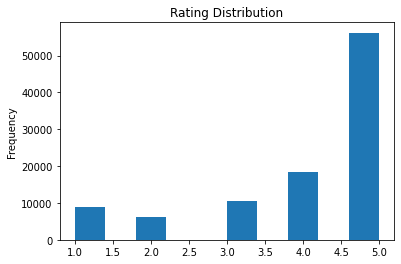

In [12]:
df['overall'].plot(kind='hist', title='Rating Distribution')

There are class imbalance problem with dataset

In [13]:
# handle class imbalance problem
rus  = RandomUnderSampler(random_state=42)
df_final, _ = rus.fit_resample(df, df['overall'])
df_final = pd.DataFrame(df_final, columns=['overall','reviewText'])
df_final.shape

(30380, 2)

In [14]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30380 entries, 0 to 30379
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   overall     30380 non-null  int32 
 1   reviewText  30380 non-null  object
dtypes: int32(1), object(1)
memory usage: 356.1+ KB


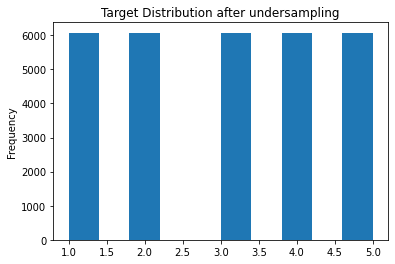

In [15]:
df_final['overall'].plot(kind='hist', title='Target Distribution after undersampling');

# Data Analysis and Preprocessing for All Dataset

In [16]:
def process_data(data_array, data_name):
  # convert list into pandas dataframe
  print('######[ Processing', data_name, 'Data ]######')

  df = pd.DataFrame.from_dict(data_array)
  df = df[['overall', 'reviewText']]

  print("Unique Rating : ", df['overall'].unique())

  df = df[df['reviewText'].notna()]

  # convert target type from float to int
  df = df.astype({'overall': 'int32'})

  df['overall'].plot(kind='hist', title='Rating Distribution of {}'.format(data_name))
  plt.show()

  # handle class imbalance problem
  rus  = RandomUnderSampler(random_state=42)
  df, _ = rus.fit_resample(df, df['overall'])
  df = pd.DataFrame(df, columns=['overall','reviewText'])
  print('Final size of data :', len(df), '\n')

  # convert target type from float to int
  df = df.astype({'overall': 'int32'})

  df['overall'].plot(kind='hist', title='Target Distribution after undersampling of {}'.format(data_name));
  plt.show()

  return df

######[ Processing Cell_Phones_and_Accessories Data ]######
Unique Rating :  [5. 3. 2. 4. 1.]


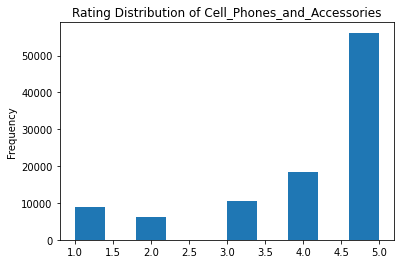

Final size of data : 30380 



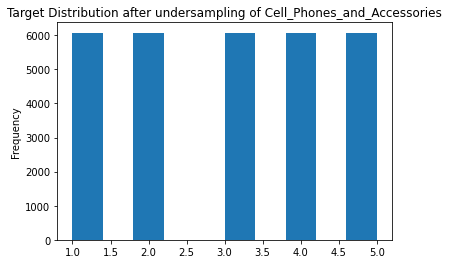

######[ Processing Arts_Crafts_and_Sewing Data ]######
Unique Rating :  [4. 5. 2. 3. 1.]


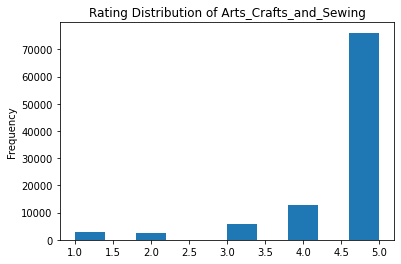

Final size of data : 12955 



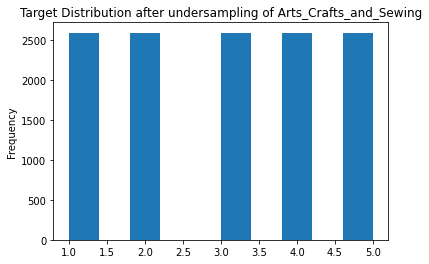

######[ Processing Clothing_Shoes_and_Jewelry Data ]######
Unique Rating :  [5. 4. 2. 3. 1.]


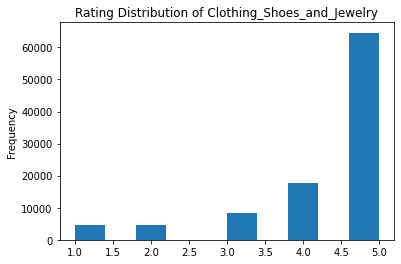

Final size of data : 22750 



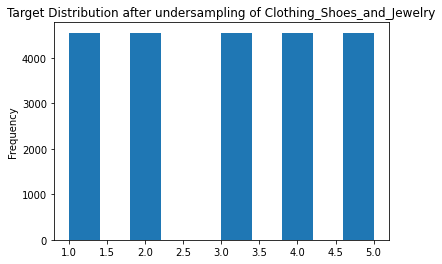

######[ Processing Books Data ]######
Unique Rating :  [5. 3. 2. 4. 1.]


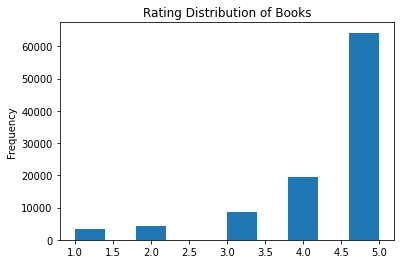

Final size of data : 17420 



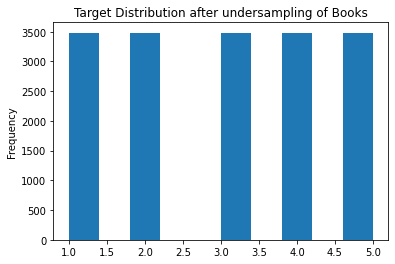

######[ Processing Electronics Data ]######
Unique Rating :  [5. 3. 4. 2. 1.]


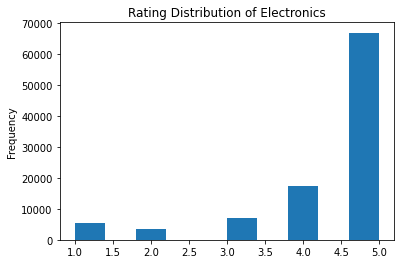

Final size of data : 17525 



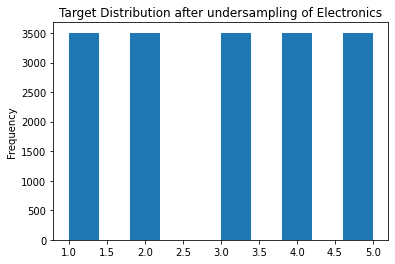

######[ Processing Kindle_Store Data ]######
Unique Rating :  [4. 5. 3. 2. 1.]


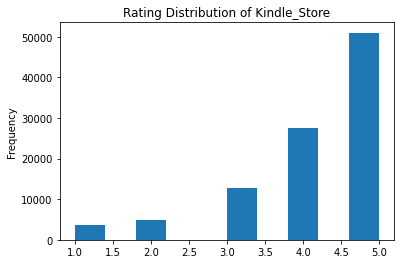

Final size of data : 18655 



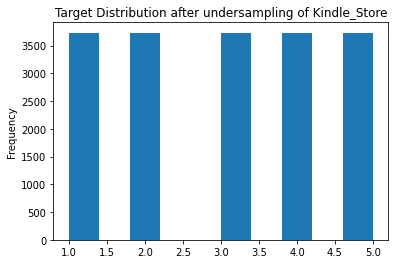

######[ Processing Sports_and_Outdoors Data ]######
Unique Rating :  [5. 1. 4. 3. 2.]


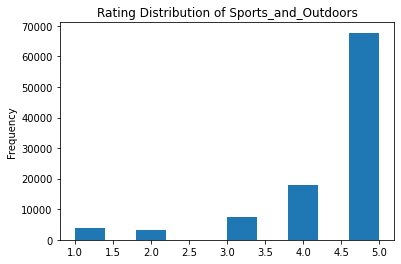

Final size of data : 16610 



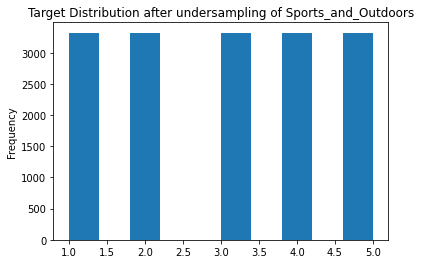

######[ Processing Toys_and_Games Data ]######
Unique Rating :  [5. 4. 2. 1. 3.]


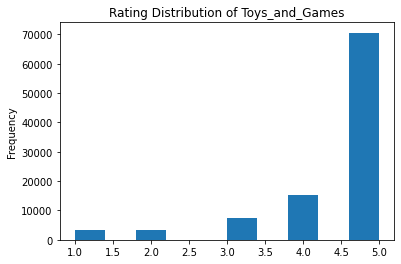

Final size of data : 16630 



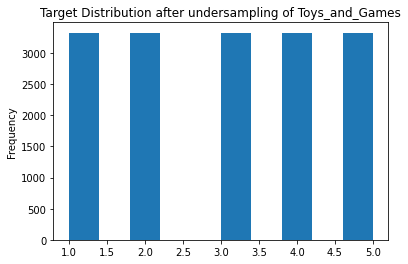

In [17]:
processed_data = {}
for data_name, data_array in data.items():
  processed_data[data_name] = process_data(data_array, data_name)

In [18]:
# Marge the data of all catagories to a single dataframe
final_data = pd.concat(processed_data.values())
final_data.shape

(152925, 2)

In [19]:
# converting rationg to binary labels (1 = Good, 0 = Bad)
y = final_data.iloc[:, 0].values > 2
y = np.array([int(i) for i in y])

In [20]:
# split data into training and validation set in ratio of 9:1
X_train, X_test, Y_train, Y_test = train_test_split(final_data['reviewText'], y, random_state=42, train_size=0.9, stratify=y)

print('No. of samples Training data :', X_train.shape[0])
print('No. of samples Validation data :', X_test.shape[0]) 

No. of samples Training data : 137632
No. of samples Validation data : 15293


In [21]:
# Get one hot encoding of Y_train
# Y_train = pd.get_dummies(Y_train)
# Y_test = pd.get_dummies(Y_test)

# Y_train.head()

# Tensorflow Word Preprocessing

In [22]:
vocab_size = 5000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

In [23]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [24]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(X_train[1])

? ? ? ? ? ? ? ? ? ? ? ? this is a rugged case but you will not be able to sync charge using a docking stand the screen cover is designed poorly and trapped air makes it difficult to see the <OOV> there is another popular case that is just as strong and will allow you to dock <OOV> the belt clip will not hold the iphone you should be aware that the phone could fall out without your knowledge if you are in a noisy area or in my case a <OOV> area with a light wind i had no idea the phone fell until i turned around and walked back the way i came
1    Characters you don't care about, exposition in...
1    This is a rugged case, but you will not be abl...
1                        pile of garbage, don't buy it
1    but definitly NOT...  tiny book..  make robot ...
1    From buying this totally waste of technology. ...
1    I am so frustrated with Anita Shreve.  I canno...
1    The only thing nice I can say is it is made of...
1                                           Toxic??!!!
Name: review

In [25]:
padded.shape

(152925, 120)

# TF Model Training

In [28]:
# Model Definition with Conv1D

inputs = tf.keras.Input(shape=(max_length))
x = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
x = tf.keras.layers.Conv1D(120, 5, activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs =  tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs, outputs)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
plot_model(model, to_file="model_plot.png", show_shapes=True)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 120, 16)           80000     
                                                                 
 conv1d_1 (Conv1D)           (None, 116, 120)          9720      
                                                                 
 global_average_pooling1d_1   (None, 120)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 32)                3872      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                           

In [30]:
num_epochs = 20
history = model.fit(padded, Y_train, epochs=num_epochs, validation_data=(testing_padded, Y_test))                                                                

Epoch 1/20
4779/4779 [==============================] - 38s 5ms/step - loss: 0.5601 - accuracy: 0.7068 - val_loss: 0.4672 - val_accuracy: 0.7806
Epoch 2/20
4779/4779 [==============================] - 23s 5ms/step - loss: 0.4496 - accuracy: 0.7899 - val_loss: 0.4376 - val_accuracy: 0.7942
Epoch 3/20
4779/4779 [==============================] - 22s 5ms/step - loss: 0.4272 - accuracy: 0.8020 - val_loss: 0.4201 - val_accuracy: 0.8044
Epoch 4/20
4779/4779 [==============================] - 22s 5ms/step - loss: 0.4161 - accuracy: 0.8090 - val_loss: 0.4103 - val_accuracy: 0.8120
Epoch 5/20
4779/4779 [==============================] - 22s 5ms/step - loss: 0.4088 - accuracy: 0.8130 - val_loss: 0.4062 - val_accuracy: 0.8152
Epoch 6/20
4779/4779 [==============================] - 23s 5ms/step - loss: 0.4034 - accuracy: 0.8159 - val_loss: 0.4023 - val_accuracy: 0.8165
Epoch 7/20
4779/4779 [==============================] - 22s 5ms/step - loss: 0.3992 - accuracy: 0.8184 - val_loss: 0.3967 - val_ac

In [31]:
model.save('/content/drive/MyDrive/Colab Notebooks/Amazon Review/model_new_1.h5')

# Evaluate Model Performance 

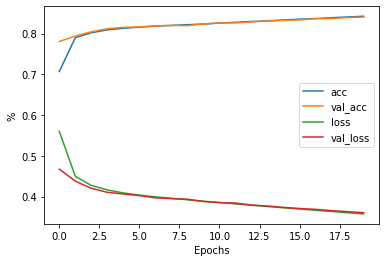

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('%')
plt.legend(['acc', 'val_acc', 'loss', 'val_loss'])
plt.show()


In [53]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(testing_padded)
y_pred = y_pred > .5


print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      6117
           1       0.87      0.87      0.87      9176

    accuracy                           0.84     15293
   macro avg       0.83      0.83      0.83     15293
weighted avg       0.84      0.84      0.84     15293



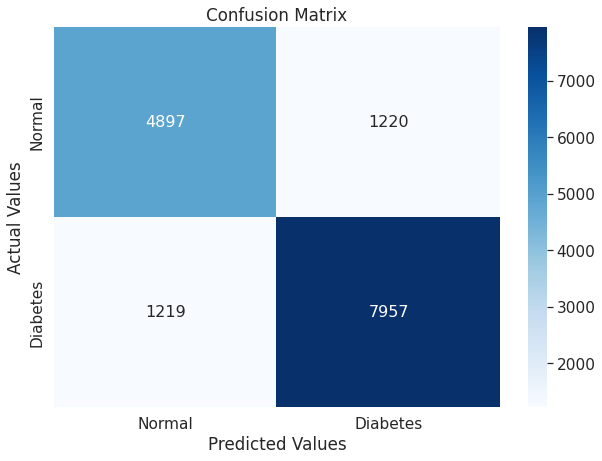


acc: 0.8405 	sensitivity: 0.8006 	specificity: 0.8672




In [50]:

cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)
sns.heatmap(cm,
            annot=True,
            annot_kws={"size": 16},
            xticklabels=['Normal', 'Diabetes'],  
            yticklabels=['Normal', 'Diabetes'],
            fmt='g',
            cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig("/content/CM.png")
plt.show()

total = np.sum(cm)

TP, FN, FP, TN = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

acc = (TP + TN) / total
sensitivity = TP / (TP+FN)
specificity = TN / (TN+FP)

print("\nacc: {:.4f}".format(acc),"\tsensitivity: {:.4f}".format(sensitivity),"\tspecificity: {:.4f}\n\n".format(specificity))



# Test With Custom Input

In [42]:
your_review = "the product is good, i am satisfied with it"

In [43]:
your_padded_review = pad_sequences(tokenizer.texts_to_sequences([your_review]), maxlen=max_length, truncating=trunc_type)
prediction = model.predict(your_padded_review)[0][0]

if prediction > 0.5:
  print('good')
else:
  print('not good')

prediction

good


0.9949615

In [44]:
your_review = "the product is vary bad, do not buy this"

In [45]:
your_padded_review = pad_sequences(tokenizer.texts_to_sequences([your_review]), maxlen=max_length, truncating=trunc_type)
prediction = model.predict(your_padded_review)[0][0]

if prediction > 0.5:
  print('good')
else:
  print('not good')

prediction

not good


0.056198005